In [1]:
import psycopg2
import matplotlib.pyplot as plt

In [2]:
conn = psycopg2.connect("dbname=project user=hugens")
cursor_psql = conn.cursor()

In [5]:
#scale = 1/30000
scale = 1

In [6]:
sql = "select st_astext(point) from stops"
cursor_psql.execute(sql)
results = cursor_psql.fetchall()
#results

In [5]:
xs_stops = []
ys_stops = []
for row in results:
    point_string = row[0]
    point_string = point_string[6:-1]
    (x,y) = point_string.split()
    xs_stops.append(float(x))
    ys_stops.append(float(y))
print(xs_stops[:5])
print(ys_stops[:5])

[-8.5288333, -8.5588777, -8.5297784, -8.53830549, -8.53824995]
[41.20608334, 41.21944054, 41.20899437, 41.21027777, 41.21016667]


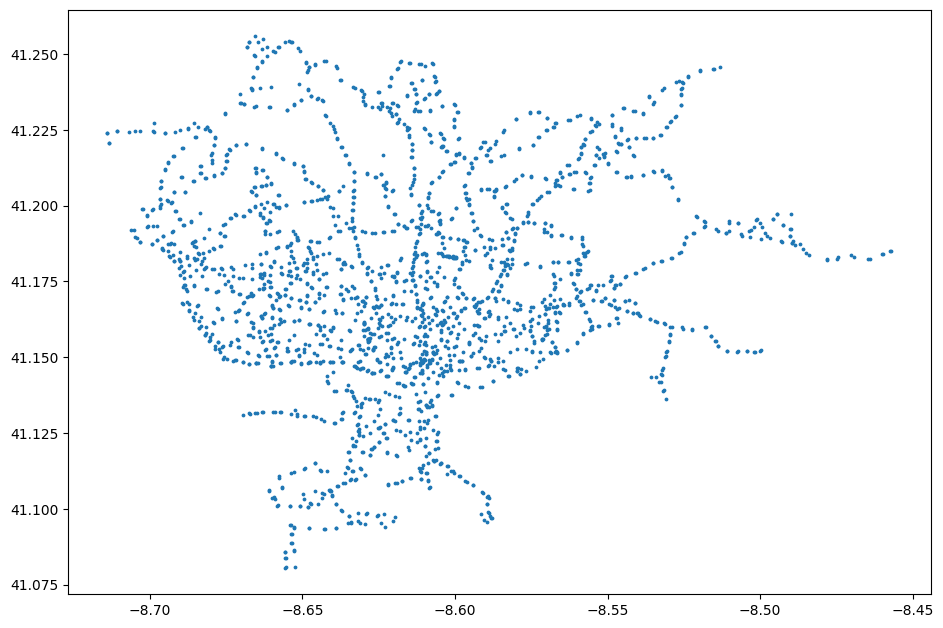

In [6]:
width_in_inches = ((max(xs_stops)-min(xs_stops))/0.0254)*1.1
height_in_inches = ((max(ys_stops)-min(ys_stops))/0.0254)*1.1
fig = plt.figure(figsize=(width_in_inches*scale, height_in_inches*scale))
plt.scatter(xs_stops,ys_stops,s=3)

In [20]:
conn = psycopg2.connect("dbname=project user=hugens")
cursor_psql = conn.cursor()
sql = "select stop_times.trip_id, stop_times.stop_id, st_astext(stops.point) from stops join stop_times on stops.stop_id = stop_times.stop_id"
cursor_psql.execute(sql)
results = cursor_psql.fetchall()
results[:5]

[('106_1_A_1', 'FRC', 'POINT(-8.6523635 41.08092721)'),
 ('106_1_A_1', 'FRCL2', 'POINT(-8.65552954 41.08066201)'),
 ('106_1_A_1', 'ISG2', 'POINT(-8.65546307 41.08371326)'),
 ('106_1_A_1', 'ACBL2', 'POINT(-8.65571403 41.0857182)'),
 ('106_1_A_1', 'VGM2', 'POINT(-8.6528143 41.08617544)')]

In [30]:
routes = {}
for trip_id, stop_times, point in results:
    routes[trip_id] = []
for trip_id, stop_times, point in results:
    routes[trip_id].append(point)

new_routes = {}
for trip_id, points_list in routes.items():
    xs = []
    ys = []
    for point in points_list:
        (x,y) = point[6:-1].split()
        xs.append(float(x))
        ys.append(float(y))
    new_routes[trip_id] = [xs,ys]
#new_routes

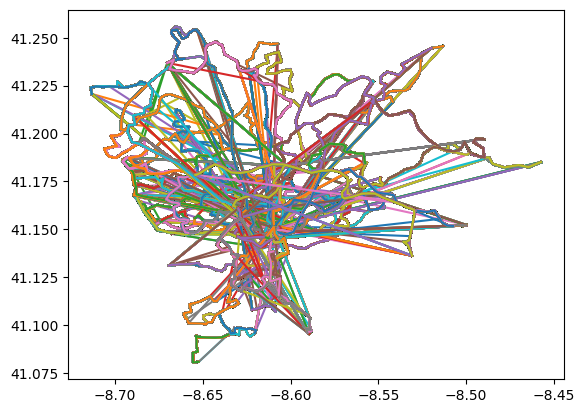

<Figure size 0.0180197x0.00688149 with 0 Axes>

In [33]:
scale = 1/30000
for trip_id, route in new_routes.items():
    xs, ys = route
    plt.plot(xs,ys)

width_in_inches = ((max(xs)-min(xs))/0.0254)*1.1
height_in_inches = ((max(ys)-min(ys))/0.0254)*1.1
fig = plt.figure(figsize=(width_in_inches*scale, height_in_inches*scale))
plt.show()

In [ ]:
# 1st query
sql = "select st_astext(st_simplify(proj_boundary,10)) from cont_aad_caop2018 where distrito='PORTO'"
sql = """select st_astext(st_simplify(proj_boundary,10)) 
        from cont_aad_caop2018 
        join (select st_transform(st_setsrid(st_point(stop_lon,stop_lat),4326),3763)) geom 
        where distrito='PORTO' and st_disjoint(proj_boundary,geom)=0"""

cursor_psql.execute(sql)
results = cursor_psql.fetchall()

xs = []
ys = []

fig = plt.figure(figsize=(10,8))

for row in results:
    xs = []
    ys = []
    #print(row[0])
    points_string = row[0]
    points_string = points_string[9:-2]
    points = points_string.split(',')
    #print(points)
    for point in points:
        (x,y) = point.split()
        xs.append(float(x))
        ys.append(float(y))
    xs.append(xs[0])
    ys.append(ys[0])
    plt.plot(xs,ys, color='red')

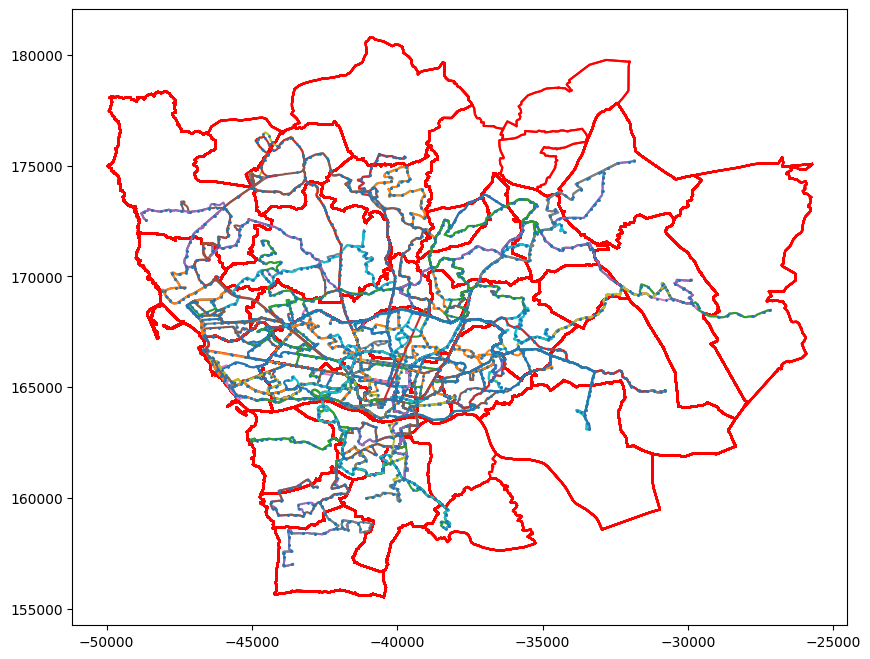

In [93]:
fig = plt.figure(figsize=(10,8))
conn = psycopg2.connect("dbname=project user=hugens")
cursor_psql = conn.cursor()

sql = """
select st_astext(st_simplify(proj_boundary,10))
from cont_aad_caop2018
join (
select st_transform(st_setsrid(st_point(stop_lon, stop_lat), 4326), 3763) as geom
from stops
) as transformed_geom on st_contains(proj_boundary, transformed_geom.geom)
where distrito = 'PORTO';
"""

cursor_psql.execute(sql)
results = cursor_psql.fetchall()

for row in results:
    xs = []
    ys = []
    points_string = row[0]
    points_string = points_string[9:-2].split(",")
    for point in points_string:
        (x,y) = point.split()
        xs.append(float(x))
        ys.append(float(y))
    plt.plot(xs,ys, color='red')

ids = {}
id = 0
sql = "SELECT shape_id from shapes;"
cursor_psql.execute(sql)
results = cursor_psql.fetchall()

shapes = []

#create ids for scatter arrays
id = 0
for s in results:
    ids[s[0]] = id
    id += 1
    shapes.append([])

# 1st query
#sql = """ select shape_id, st_astext(st_linefrommultipoint(st_collect(st_transform(st_setsrid(st_point(shape_pt_lon,shape_pt_lat),4326),3763)))), shape_pt_sequence from shapes order by shape_pt_sequence group by shape_id"""
sql = """SELECT shape_id, 
       ST_AsText(ST_Transform(ST_SetSRID(ST_Point(shape_pt_lon, shape_pt_lat), 4326), 3763)) AS geometry,
       shape_pt_sequence
        FROM shapes
"""
cursor_psql.execute(sql)
results = cursor_psql.fetchall()

dic = {}
dic_id = 0

for result in results:
    id_p = result[0]
    id_s = ids[id_p]
    sequence = int(result[2])
    ps = result[1][6:-1].split()
    x = float(ps[0])
    y = float(ps[1])
    shapes[id_s].append((sequence,x,y))

for s in shapes:
    s = sorted(s,key=lambda x:s[0])

for row in shapes:
    xs = []
    ys = []
    for p in row:
        x = float(p[1])
        y = float(p[2])
        xs.append(x)
        ys.append(y)
    plt.plot(xs,ys)

# 2nd query
sql = """select st_astext(st_transform(st_setsrid(st_point(stop_lon,stop_lat),4326),3763)) from stops"""
cursor_psql.execute(sql)
results = cursor_psql.fetchall()
#print(results)

xs = []
ys = []
for row in results:
    point_string = row[0]
    point_string = point_string[6:-1]
    x,y = point_string.split(" ")
    xs.append(float(x))
    ys.append(float(y))
plt.scatter(xs,ys,s=1,zorder=3)